In [ ]:
"""
Preparando para Colab e importando librerías necesarias.
El archivo ".mos" de entrada debe ser a una columna con las cuentas por canal y sin encabezado
"""
!pip install lmfit
from google.colab import drive
drive.mount('/content/drive/')
img = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/19NOV14.mos'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit import Parameters, minimize, fit_report
from scipy.constants import *
from scipy.integrate import trapz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Ingrese la fecha de calibración (AAAAMMDD): 20141119
Ingrese el rango de V (en mm/s): 7.55


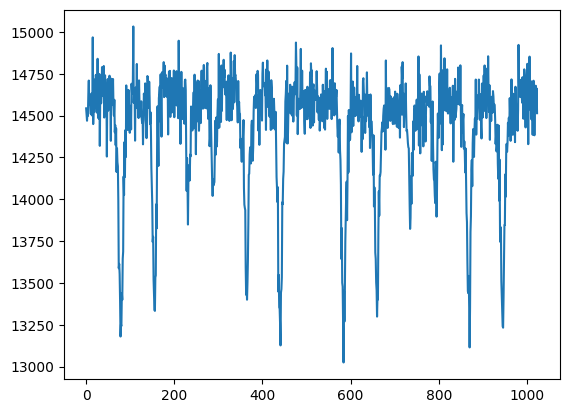

29185


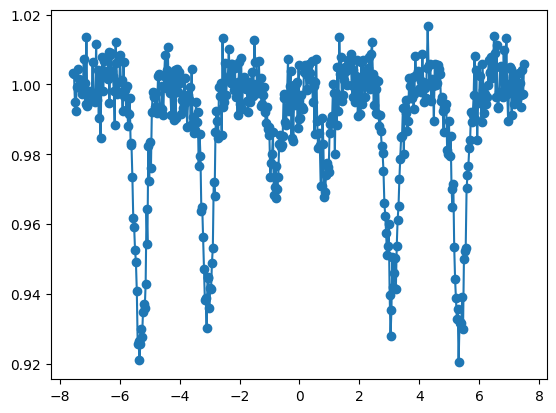

In [ ]:
"""
Para doblar, normalizar y calibrar en mm/s, los archivos del espectrómetro de INTECIN de 1024 canales
"""
fecha = str(input('Ingrese la fecha de calibración (AAAAMMDD): '),)
vel = float(input('Ingrese el rango de V (en mm/s): ' ), )

np.savetxt('/content/drive/MyDrive/Colab-Notebooks/PyMossFit/calib.txt', (fecha,vel), fmt='%s')

y= np.loadtxt(img)

plt.plot(y)
plt.show()

for i in range(0, 511):
    y[[i]]=y[[i]]+y[[511+i]]

y=y[0:511]

"""
Normalización
"""
y2=[y[0:59],y[451:510]]

ymax=np.mean(y2)
ymax=int(ymax)

print(ymax)

for i in range(0, 511):
    y[[i]]=y[[i]]/ymax

x=np.arange(1,512)

"""
de canales a escala de velocidades en mm/s
"""
v=np.loadtxt('/content/drive/MyDrive/Colab-Notebooks/PyMossFit/calib.txt'); vmax=v[[1]]

x=np.linspace(start = 0, stop = 511, num= 512)

for i in range(0, 511):
    x[[i]]=(i-256)*vmax/256

x=x[0:511]

plt.plot(x,y, marker="o")
plt.show()

np.savetxt('/content/drive/MyDrive/Colab-Notebooks/PyMossFit/19NOV14.csv', list(zip(x,y)), delimiter=",", fmt='%1.6f')

ancho (sigma/sqrt(2)) es: 0.24 mm/s
Centroide (ISO1) es: 0.014 mm/s
Amplitud (a) es: 0.0141
B (Campo) es: 33.1 T
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 84
    # data points      = 511
    # variables        = 6
    chi-square         = 0.02547836
    reduced chi-square = 5.0452e-05
    Akaike info crit   = -5050.11698
    Bayesian info crit = -5024.69877
[[Variables]]
    b:    0.34353465 +/- 0.00996990 (2.90%) (init = 0.3)
    m:    0.01357491 +/- 0.00372215 (27.42%) (init = -0.11)
    d:    1.06448772 +/- 0.00102798 (0.10%) (init = 1.07)
    a:    0.01408903 +/- 3.3278e-04 (2.36%) (init = 0.13)
    q:    0.12083000 +/- 0.00671016 (5.55%) (init = 0)
    l23:  2.59029992 +/- 0.08241252 (3.18%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, a)   = +0.5675
    C(a, l23) = -0.5274
    C(d, q)   = +0.4582


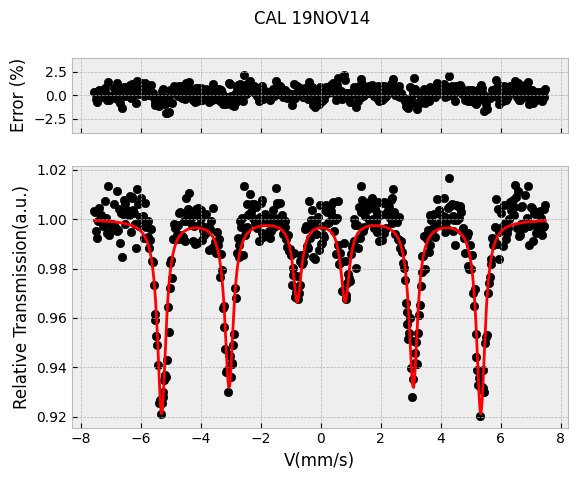

In [19]:
"""
LECTURA DE ARCHIVO DE ENTRADA
"""
col_list=[0, 1]

x, y= np.loadtxt("/content/drive/MyDrive/Colab-Notebooks/PyMossFit/19NOV14.csv", delimiter=",", usecols=col_list, unpack=True)

"""
DEFINICIÓN DE LAS FUNCIONES BASADAS EN LORENTZIANAS
"""
def singlet(a, b, m, x):
    return 2*a*b/(pi*(b**2+4*(x-m)**2))

def doublet(a, b, m, d, x):
    return 2*a*b/(pi*(b**2+4*(x-(m-d))**2))+2*a*b/(pi*(b**2+4*(x-(m+d))**2))

def sextet(a, b, m, d, q, l23, x):
    return 6*a*b/(pi*(b**2+4*(x-(m+5*d))**2))+l23*2*a*b/(pi*(b**2+4*(x-(m+3*d-q))**2))+2.5*a*b/(pi*(b**2+4*(x-(m+0.75*d))**2))+2.5*a*b/(pi*(b**2+4*(x-(m-0.75*d))**2))+l23*2*a*b/(pi*(b**2+4*(x-(m-3*d+q))**2))+6*a*b/(pi*(b**2+4*(x-(m-5*d))**2))

def linear_fitting_lmfit(params, x, y):
    b= params['b']; m= params['m']; d= params['d']; a= params['a']; q= params['q']; l23= params['l23']

    y_fit= 1-(sextet(a, b, m, d, q, l23, x))

    return y_fit-y

"""
AJUSTE DE LOS PARÁMETROS USANDO LOS DATOS EXPERIMENTALES
"""
params= Parameters()

params.add('b', value= 0.3, vary=True)
params.add('m', value= -0.11, vary=True)
params.add('d', value= 1.07, vary=True)
params.add('a', value= 0.13, vary=True)
params.add('q', value= 0.0, vary=True)
params.add('l23', value= 2.0, vary=True)

fitted_params= minimize(linear_fitting_lmfit, params, args=(x, y,), method='least_square')

m= fitted_params.params['m'].value
b= fitted_params.params['b'].value
d= fitted_params.params['d'].value
a= fitted_params.params['a'].value
q= fitted_params.params['q'].value
l23= fitted_params.params['l23'].value


"""
CREACIÓN DE LOS SUBESPECTROS AJUSTADOS
"""
z= 1-(sextet(a, b, m, d, q, l23, x))
e= (y-z)*100

"""
INTEGRAL DE ÁREAS Y GENERACIÓN DE LOS PARÁMETROS HIPERFINOS. REPORTE EN PANTALLA
"""
i= trapz(1-z, x) #Las áreas de subespectros se calculan como: i= trapz(1-z, x); i1= trapz(1-z1, x)/i*100; i2=trapz(1-z2, x)/i*100; etc con z=z1+z2+...

b= "{0:.2f}".format(b/np.sqrt(2))
m= "{0:.3f}".format(m)
h= "{0:.1f}".format(5*d*33/5.312)
a= "{0:.4f}".format(a)
q= "{0:.2f}".format(q)
l23= "{0:.1f}".format(l23)
i= "{0:.1f}".format(abs(i))


print('ancho (sigma/sqrt(2)) es:', b, 'mm/s')
print('Centroide (ISO1) es:', m, 'mm/s')
print('Amplitud (a) es:', a)
print('B (Campo) es:', h, 'T')
#print('área:', i, '%')
print(fit_report(fitted_params))

"""
GRAFICA DE ESPECTROS Y SUBESPECTROS
"""
plt.style.use('bmh')
#plt.figure(figsize=(18, 10))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, height_ratios=[1,3.5]); fig.suptitle("CAL 19NOV14")
ax1.scatter (x, e, c= 'black')
ax1.set_ylim(-4,4)
ax1.set_ylabel('Error (%)'); #plt.axis('tight')

ax2.scatter (x, y, c= 'black')
ax2.set_xlabel('V(mm/s)')
ax2.set_ylabel('Relative Transmission(a.u.)')
ax2.plot(x, z, c='red')

plt.show()

"""
GENERACIÓN DE ARCHIVOS DE SALIDA: DATOS Y PARÁMETROS
"""
np.savetxt('/content/drive/MyDrive/Colab-Notebooks/PyMossFit/19NOV14-plot.csv', list(zip(x, y, z)), delimiter=',', fmt='%1.6e')

df= pd.DataFrame ({'Ancho(mm/s)': [b], 'ISO (mm/s)': [m], 'Quadrupolar shift': [q],'H/QUAD(T/mm-s)': [h], 'Área(%)': [i]})
df.to_csv('/content/drive/MyDrive/Colab-Notebooks/PyMossFit/19NOV14_report.csv', index=False)